In [1]:
import os
import os.path as op
import glob
import torch
import torch.nn as nn
import pandas as pd
import numpy as np 
import xml.etree.ElementTree as ET
import pickle
from scipy.io import loadmat
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.notebook import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
import math

Difference between highest object count and lowest object count across categories: 104
Standard deviation of test obejct counts: 23.2208975716619


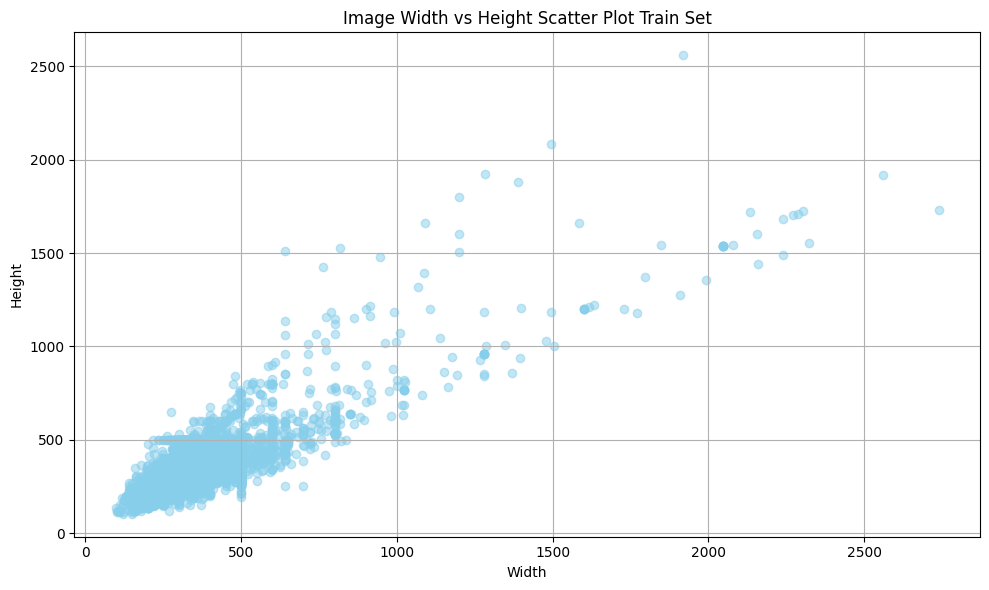

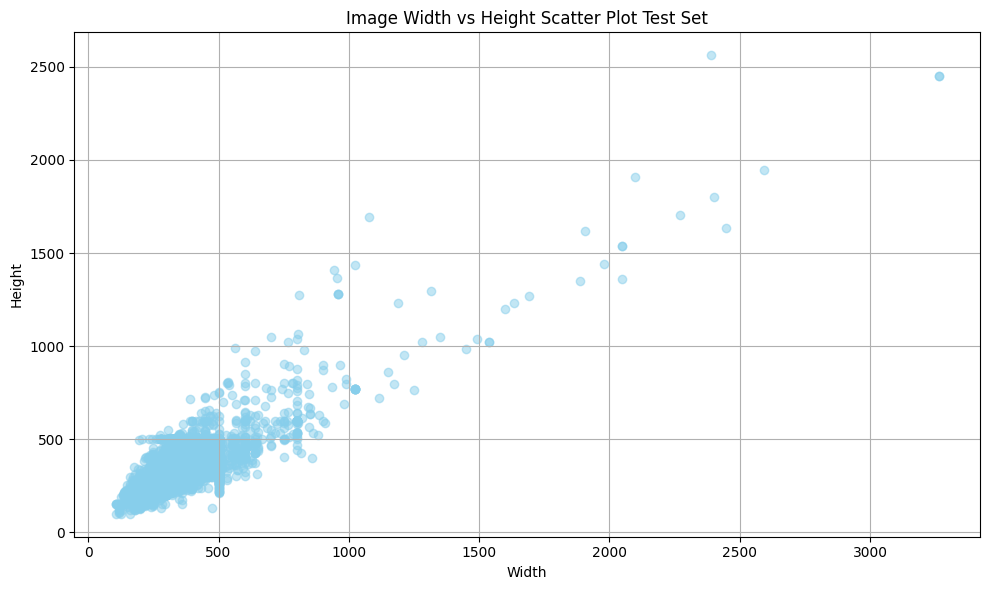

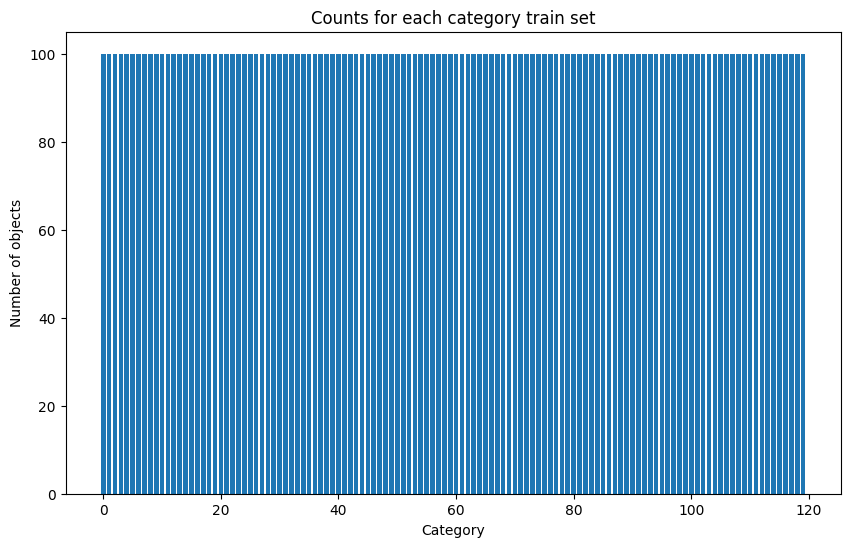

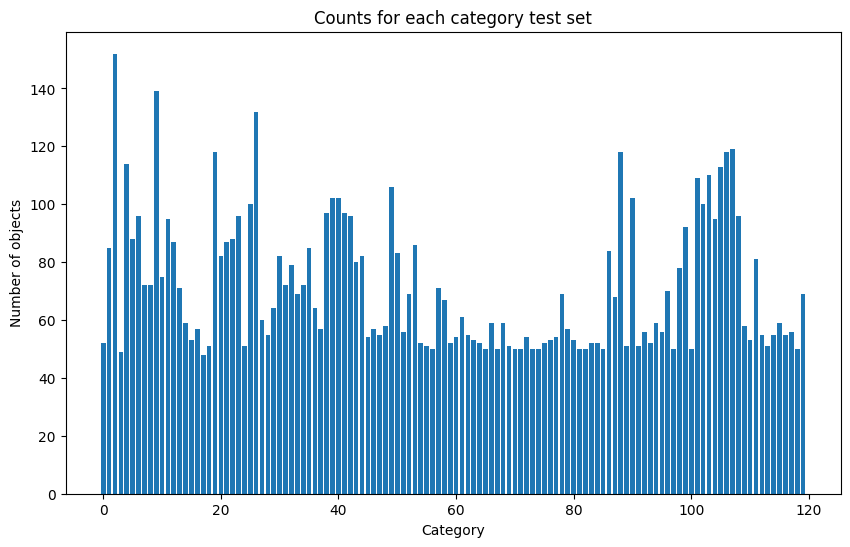

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset():

    # Get train list
    f = loadmat("lists/train_list.mat")
    train_images = [x[0][0] for x in f['file_list']]
    train_labels = [x[0] for x in f['labels']]

    # Get file list
    f = loadmat("lists/test_list.mat")
    test_images = [x[0][0] for x in f['file_list']]
    test_labels = [x[0] for x in f['labels']]
    
    # Gather data
    train_data = []
    test_data = []

    # Record category ids
    categories = {}

    for i in range(len(train_images) + len(test_images)):

        # Determine if train or test
        image = train_images[i] if i < len(train_images) else test_images[i - len(train_images)]
        label = train_labels[i] if i < len(train_images) else test_labels[i - len(train_images)]
        label_name = os.path.split(image)[0]
        # Label -1 to make it 0-indexed
        categories[label_name] = label-1
        annotation_path = os.path.join("Annotation", image.replace(".jpg", ""))

        # Read XML
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)

        bndbox = root.find("object").find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Append to data
        if i < len(train_images):
            train_data.append(dict(
                image=os.path.join("Images", image),
                label=label-1,
                label_name=label_name,
                width=width,
                height=height,
                xmin=xmin,
                ymin=ymin,
                xmax=xmax,
                ymax=ymax
            ))
        else:
            test_data.append(dict(
                image=os.path.join("Images", image),
                label=label-1,
                label_name=label_name,
                width=width,
                height=height,
                xmin=xmin,
                ymin=ymin,
                xmax=xmax,
                ymax=ymax
            ))


    return train_data, test_data, categories

def numerical_analysis(dftrain, dftest):
    count_category_train = {}
    width_height_list_train = []
    # Count the number of objects per category train set 
    for index, row in dftrain.iterrows():
        width = row['width']
        height = row['height']
        width_height_list_train.append([width, height])
        label = row['label']
        if label in count_category_train:
            count_category_train[label] +=1
        else:
            count_category_train[label] = 1
            
    # Count the number of objects per category test set       
    count_category_test = {}
    width_height_list_test = []
    for index, row in dftest.iterrows():
        width = row['width']
        height = row['height']
        width_height_list_test.append([width, height])
        label = row['label']
        if label in count_category_test:
            count_category_test[label] +=1
        else:
            count_category_test[label] = 1

    # Caculate Difference between highest object count and lowest object count across categories
    highest_count = max(count_category_test.values())
    smallest_count = min(count_category_test.values())
    difference = highest_count - smallest_count
    print(f"Difference between highest object count and lowest object count across categories: {difference}")

    # Caculate standard deviation
    object_counts = list(count_category_test.values())
    total = sum(object_counts)
    mean = total / len(object_counts)
    squared_deviations = [ (x - mean)**2 for x in object_counts]
    sum_of_squared_deviations = sum(squared_deviations)
    n_minus_one = len(object_counts) - 1
    standard_deviation = math.sqrt(sum_of_squared_deviations / n_minus_one)
    print(f"Standard deviation of test obejct counts: {standard_deviation}")
    
    widths_train = [coord[0] for coord in width_height_list_train]
    heights_train = [coord[1] for coord in width_height_list_train]

    # Plot the scatter graph for train set
    plt.figure(figsize=(10, 6))
    plt.scatter(widths_train, heights_train, color='skyblue', marker='o', alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Width vs Height Scatter Plot Train Set')
    plt.grid(True)
    plt.tight_layout()  
    plt.savefig('scatter_graph_train.png')
    plt.show()

    widths_test = [coord[0] for coord in width_height_list_test]
    heights_test = [coord[1] for coord in width_height_list_test]

    # Plot the scatter graph for test set
    plt.figure(figsize=(10, 6))
    plt.scatter(widths_test, heights_test, color='skyblue', marker='o', alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Width vs Height Scatter Plot Test Set')
    plt.grid(True)
    plt.tight_layout() 
    plt.savefig('scatter_graph_test.png')
    plt.show()

    # Extract keys and values
    keys_train = list(count_category_train.keys())
    values_train = list(count_category_train.values())
    
    # Plot category counts
    plt.figure(figsize=(10, 6))
    plt.bar(keys_train, values_train)
    plt.title('Counts for each category train set')
    plt.xlabel('Category')
    plt.ylabel('Number of objects')
    plt.savefig('bar_graph_train.png')
    plt.show()

    # Extract keys and values
    keys_test = list(count_category_test.keys())
    values_test = list(count_category_test.values())
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(keys_test, values_test)
    plt.title('Counts for each category test set')
    plt.xlabel('Category')
    plt.ylabel('Number of objects')
    plt.savefig('bar_graph_test.png')
    plt.show()
        
    
# Read dataset and gather into dataframe
train_data, test_data, categories = load_dataset()
dftrain = pd.DataFrame(train_data)
dftest = pd.DataFrame(test_data)
numerical_analysis(dftrain, dftest)



In [ ]:
# Get the classes summary
print("Number of classes: ", len(categories))
print("Number of training samples: ", len(dftrain))
print("Number of testing samples: ", len(dftest))

In [ ]:
# Inherit from Dataset
class CustomDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image'])
        image = image.convert('RGB')
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return image, label
        

train_transforms = transforms.Compose([
    # Randomly resize and crop the image to 224
    transforms.RandomResizedCrop(224),
    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),
    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    # Resize the image to 256
    transforms.Resize(256),
    # Crop the center of the image
    transforms.CenterCrop(224),
    # Convert the image to a PyTorch Tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



train_dataset = CustomDataset(dftrain, transform=train_transforms)
test_dataset = CustomDataset(dftest, transform=test_transforms)


In [ ]:
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152
from torchvision.models import (
    efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3,
    vit_b_16, vit_b_32, vit_l_16, vit_l_32, 
)


class TwoLayersCNN(nn.Module):

    def __init__(self, num_classes):
        super(TwoLayersCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def build_model(model_name):
    if model_name == 'twolayerscnn':
        model = TwoLayersCNN(len(categories))
    elif model_name == 'resnet18':
        model = resnet18(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
    elif model_name == 'resnet34':
        model = resnet34(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
    elif model_name == 'resnet50':
        model = resnet50(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
    elif model_name == 'resnet101':
        model = resnet101(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
    elif model_name == 'resnet152':
        model = resnet152(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, len(categories))
    elif model_name == 'efficientnet_b0':
        model = efficientnet_b0(pretrained=True)
        classifier = model.classifier
        dropoutrate = classifier[0].p
        infeatures = classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropoutrate),
            nn.Linear(infeatures, len(categories))
        )
    elif model_name == 'efficientnet_b1':
        model = efficientnet_b1(pretrained=True)
        classifier = model.classifier
        dropoutrate = classifier[0].p
        infeatures = classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropoutrate),
            nn.Linear(infeatures, len(categories))
        )
    elif model_name == 'efficientnet_b2':
        model = efficientnet_b2(pretrained=True)
        classifier = model.classifier
        dropoutrate = classifier[0].p
        infeatures = classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropoutrate),
            nn.Linear(infeatures, len(categories))
        )
    elif model_name == 'efficientnet_b3':
        model = efficientnet_b3(pretrained=True)
        classifier = model.classifier
        dropoutrate = classifier[0].p
        infeatures = classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=dropoutrate),
            nn.Linear(infeatures, len(categories))
        )
    elif model_name == 'vit_b_16':
        model = vit_b_16(pretrained=True)
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(categories))
    elif model_name == 'vit_b_32':
        model = vit_b_32(pretrained=True)
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(categories))
    elif model_name == 'vit_l_16':
        model = vit_l_16(pretrained=True)
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(categories))
    elif model_name == 'vit_l_32':
        model = vit_l_32(pretrained=True)
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(categories))
    else:
        raise ValueError("Model not supported")
    
    return model


def train_model(model, batch_size=32):
    """
    Train the model, this function will return a dictionary containing the training and testing loss and accuracy
    """
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print(train_dataloader)
    print(test_dataloader)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=3, verbose=True, factor=0.1)

    train_losses = []
    test_losses = []
    train_iters_per_epoch = len(train_dataloader)
    test_iters_per_epoch = len(test_dataloader)
    train_accs = []
    test_accs = []

    epoch = 1
    while True:

        model.train()
        for images, labels in tqdm(train_dataloader, desc="Train Epoch " + str(epoch)):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        # Evaluate the model
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc="Test Epoch " + str(epoch)):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        test_accs.append(metrics.accuracy_score(y_true, y_pred))

        # Evaluate the model on training set
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in tqdm(train_dataloader, desc="Train Epoch " + str(epoch)):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        train_accs.append(metrics.accuracy_score(y_true, y_pred))

        # Print the loss and accuracy
        print("Train Loss: ", np.mean(train_losses[-train_iters_per_epoch:]))
        print("Test Loss: ", np.mean(test_losses[-test_iters_per_epoch:]))
        print("Train Accuracy: ", train_accs[-1])
        print("Test Accuracy: ", test_accs[-1])
        
        scheduler.step(test_accs[-1])
        if optimizer.param_groups[0]['lr'] < 1e-6:
            print("Learning rate is too low, stopping training")
            break
        epoch += 1

    return dict(
        train_iters_per_epoch=train_iters_per_epoch,
        test_iters_per_epoch=test_iters_per_epoch,
        train_losses=train_losses,
        test_losses=test_losses,
        train_accs=train_accs,
        test_accs=test_accs
    )


def plot_history(history, ax=None):
    if ax is None:
        ax = plt.gca()
    train_iters_per_epoch = history['train_iters_per_epoch']
    test_iters_per_epoch = history['test_iters_per_epoch']
    train_losses = history['train_losses']
    test_losses = history['test_losses']
    train_accs = history['train_accs']
    test_accs = history['test_accs']
    # Dual axis
    train_losses = np.array(train_losses)
    # Exponential moving average
    train_losses_smooth = np.zeros_like(train_losses)
    train_losses_smooth[0] = train_losses[0]
    for i in range(1, len(train_losses)):
        train_losses_smooth[i] = 0.9 * train_losses_smooth[i-1] + 0.1 * train_losses[i]
    test_losses = np.array(test_losses)
    test_losses_smooth = np.zeros_like(test_losses)
    test_losses_smooth[0] = test_losses[0]
    for i in range(1, len(test_losses)):
        test_losses_smooth[i] = 0.9 * test_losses_smooth[i-1] + 0.1 * test_losses[i]
    ax2 = ax.twinx()
    ax.plot(np.arange(len(train_losses)) / train_iters_per_epoch, train_losses, label="Train Loss", color='tab:blue', alpha=0.5)
    ax.plot(np.arange(len(test_losses)) / test_iters_per_epoch, test_losses, label="Test Loss", color='tab:orange', alpha=0.5)
    ax.plot(np.arange(len(train_losses)) / train_iters_per_epoch, train_losses_smooth, color='tab:blue')
    ax.plot(np.arange(len(test_losses)) / test_iters_per_epoch, test_losses_smooth, color='tab:orange')
    ax2.plot(np.arange(len(train_accs)), train_accs, label="Train Accuracy", color='tab:green')
    ax2.plot(np.arange(len(test_accs)), test_accs, label="Test Accuracy", color='tab:red')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid()
    return ax

In [ ]:
resnets = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
efficientnets = ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2", "efficientnet_b3",
                 "efficientnet_b4", "efficientnet_b5", "efficientnet_b6", "efficientnet_b7"]
vits = ["vit_b_16", "vit_b_32", "vit_l_16", "vit_l_32"]

for model_name in ['twolayerscnn']:
    for batch_size in [32, 64, 128]:
        try:
            name = model_name + "_" + str(batch_size)
            path_history = op.join("Histories", name + ".pkl")
            path_model = op.join("Histories", name + ".pth")
            if op.exists(path_history):
                print("Model", name, "already trained, skipping")
                continue
            model = build_model(model_name).to(device)
            history = train_model(model, batch_size=batch_size)
            with open(path_history, "wb") as f:
                pickle.dump(history, f)
            torch.save(model.state_dict(), path_model)
            print("Model", name, "trained and saved")
        # OOM
        except RuntimeError as e:
            print("Model", name, "OOM, skipping")
        except Exception as e:
            print("Model", name, "Error", e)
            continue

E:\ProjectsMasters\GroupProjectAppsOfMl\venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:
histories = glob.glob("Histories/*.pkl")

data = []
for hist in histories:
    with open(hist, "rb") as f:
        history = pickle.load(f)
    model_name = op.basename(hist).replace(".pkl", "")
    model_name_list = model_name.split("_")
    model_name = "_".join(model_name_list[:-1])
    batch_size = int(model_name_list[-1])

    data.append(dict(
        model=model_name,
        batch_size=batch_size,
        train_acc_best="{:.4f}".format(max(history['train_accs'])),
        test_acc_best="{:.4f}".format(max(history['test_accs'])),
    ))

result_df = pd.DataFrame(data)
print(result_df.to_markdown())

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(15, 15))
axes = axes.flatten()

for i, hist in enumerate(histories):
    with open(hist, "rb") as f:
        history = pickle.load(f)
    name = op.basename(hist).replace(".pkl", "")
    ax = axes[i]
    plot_history(history, ax=ax)
    ax.set_title(name)
    

plt.tight_layout()
plt.show()